# Chunk Sampling Planner

As a result of trying light pretraining on sequential tiles, a non-generalized representation of the landscape has emerged which so to better POC we will create a preplanned chunk schedule which can be retrieved via scripts to use for pretraining

In [435]:
import os
import rasterio
import random
import numpy as np
import geopandas as gd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely import box
from functools import partial
from dotenv import load_dotenv

In [30]:
sns.set_style('darkgrid')

In [4]:
load_dotenv()

True

In [7]:
root = os.getenv('DATA_ROOT')

## Load Shape Files

In [537]:
ca_tiles = gd.read_file(f'{root}/shp/TILE_INDEX.shp/tile_index.shp')
ca_tiles = ca_tiles.sort_values(['row', 'col']).reset_index(drop=True)

In [9]:
world_shp = gd.read_file(f'{root}/shp/ne_10m/ne_10m_admin_1_states_provinces.shp')
ca = world_shp[world_shp.name.eq('California')]

In [10]:
city_shp = gd.read_file(f'{root}/shp/cities/CityBoundaries.shp')
city_ca = city_shp[city_shp['ST'] == 'CA']
city_ca = city_ca.to_crs(ca.crs)

## Determine Measures

In [215]:
# One time run to determine metrics
#blocks = []
#windows = []

#with rasterio.open(f'{root}/shp/california_R01C09.tif') as tif:
#    cell_x, cell_y = tif.res
#    for block, window in tif.block_windows(1):
#        blocks.append(block)
#        windows.append(window)

#print(cell_x, cell_y, blocks[-1])

In [434]:
block_size = 235
chunk_size = 256
chunk_agg = 3
cell_c = 8.98315284119521e-06
cell_r = 8.98315284119521e-06
n_samples = 75_000

this gives us the pixel to meter measures and the number of chunks within the tile 234x234

## Plan Samples

In [512]:
def get_blocks(size: int) -> list:
    return [(i, j) for i in range(size) for j in range(size)]

def get_block_df(blocks: list) -> pd.DataFrame:
    return pd.DataFrame({
        'block_r': [block[0] for block in blocks],
        'block_c': [block[1] for block in blocks] 
    })

def filter_block(block: tuple, size: int, agg: int=1) -> bool:
    offset = size - agg

    c_st_check = block[1] % agg == 0
    r_st_check = block[0] % agg == 0
    c_en_check = block[1] < offset
    r_en_check = block[0] < offset

    return c_st_check and c_en_check and r_st_check and r_en_check

def get_agg_blocks(size: int, agg: int=3) -> list:
    return [block for block in get_blocks(size) if filter_block(block, size, agg)]

def get_tile(shp, r: int, c: int):
    r_shp = shp['row'] == str(r).zfill(2)
    c_shp = shp['col'] == str(c).zfill(2)
    return shp[r_shp & c_shp].iloc[0]

def get_tile_by_idx(shp, idx: int):
    return shp.iloc[idx]

def get_tile_bounds(til) -> list:
    return til.geometry.bounds

def get_chunk_bounds(block: tuple,
                     bounds: list,
                     chunk_size: int,
                     agg: int,
                     cell_c: float,
                     cell_r: float) -> list:
    minx, _, _, maxy = bounds
    r, c = block

    c1 = minx + cell_c * c * chunk_size
    c2 = c1 + cell_c * chunk_size * agg

    r2 = maxy - cell_r * r * chunk_size
    r1 = r2 - cell_r * chunk_size * agg

    return c1, r1, c2, r2

def compute_geo_coords(row,
                       tile_bounds,
                       chunk_size=chunk_size,
                       agg=chunk_agg,
                       cell_r=cell_r,
                       cell_c=cell_c) -> pd.Series:
    block = (row['block_r'], row['block_c'])

    bounds = get_chunk_bounds(block,
                              tile_bounds,
                              chunk_size,
                              agg,
                              cell_r,
                              cell_c)

    return pd.Series(bounds)

def check_geo_bounds(row, shp) -> bool:
    bounds = (row['x1'], row['y1'], row['x2'], row['y2'])
    return shp.contains(box(*bounds)).any()

def get_chunk_geo(til, chunk):
    row = til.iloc[0]

    return gd.GeoDataFrame({
        'geometry': [chunk],
        'state': [row['state']],
        'tile_id': [row['id']],
        'col': [int(row['col'])],
        'row': [int(row['row'])]
    }, crs=til.crs)

### Filter Tiles

In [670]:
def is_within_threshold(geom, shp: gd.GeoDataFrame, threshold: float=0.01) -> bool:
    df = gd.GeoDataFrame({'geometry': [geom]}, crs=shp.crs)
    ov = shp.overlay(df).geometry

    if len(ov) == 0:
        return False

    within = ov.iloc[0].area / geom.area
    return within >= threshold

In [671]:
ca_tiles['inbounds'] = ca_tiles['geometry'].apply(lambda tile: ca.covers(tile) | (ca.overlaps(tile) & is_within_threshold(tile, ca)))

Text(0, 0.5, 'Count')

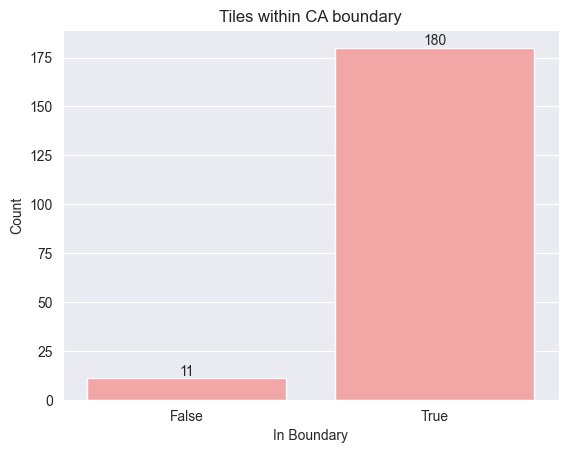

In [672]:
ax = sns.countplot(ca_tiles, color='#FF9999', x='inbounds')
ax.bar_label(ax.containers[0])
ax.set_title('Tiles within CA boundary')
ax.set_xlabel('In Boundary')
ax.set_ylabel('Count')

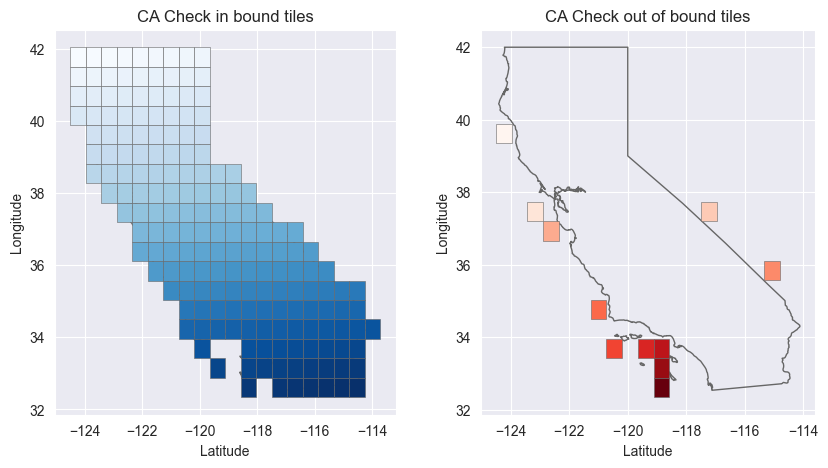

In [673]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ca.plot(facecolor='none', ax=ax, edgecolor=".4")
ca_tiles[ca_tiles['inbounds'] == True].plot(ax=ax, cmap='Blues', linewidth=0.4, edgecolor=".4")
ax.set_title('CA Check in bound tiles')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

ax = axs[1]
ca.plot(facecolor='none', ax=ax, edgecolor=".4")
ca_tiles[ca_tiles['inbounds'] == False].plot(ax=ax, cmap='Reds', linewidth=0.4, edgecolor=".4")
ax.set_title('CA Check out of bound tiles')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

In [680]:
ca_inbound_tiles = ca_tiles[ca_tiles['inbounds'] == True].reset_index(drop=True)

In [681]:
ca_inbound_tiles.shape

(180, 7)

### Assign Tiles

In [682]:
tiles = np.random.choice(ca_inbound_tiles.shape[0], n_samples)
tiles = pd.DataFrame(tiles, columns=['Tile'])

Text(0.5, 1.0, 'Tile distribution')

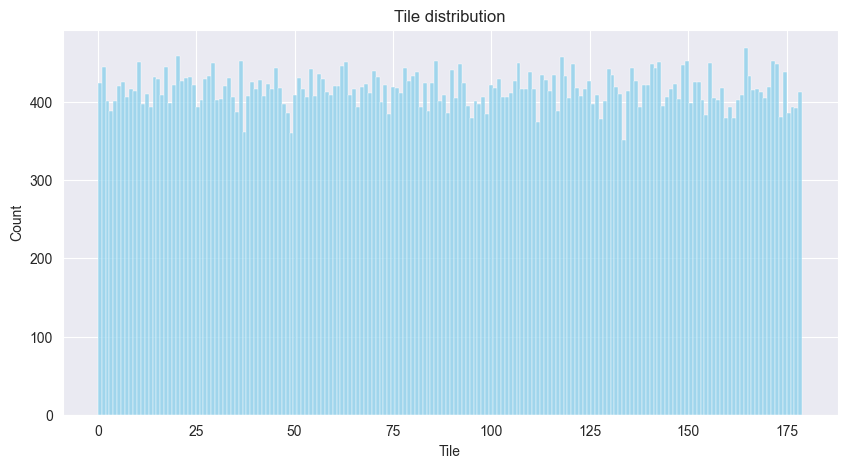

In [683]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(tiles, x='Tile', bins=ca_inbound_tiles.shape[0], color='skyblue')
ax.set_xlabel('Tile')
ax.set_ylabel('Count')
ax.set_title('Tile distribution')

### Run Sampling

In [684]:
tile_counts = tiles.groupby('Tile').size()

The approach is a trim down instead of build up approach implementation is easier but is definitely slower to have to check the boundary conditions of 50k+ chunks per tile as opposed to shuffling the blocks pulling off one by one and checking until a build up of n occurs

In [686]:
def get_tile_selections(tile_counts, block_size, tiles, state) -> pd.DataFrame:
    df = []

    block_df = get_block_df(get_blocks(block_size))
    bound_checker = partial(check_geo_bounds, shp=state)

    for tile_idx, count in enumerate(tile_counts):
        tile = get_tile_by_idx(tiles, tile_idx)
        tile_bounds = get_tile_bounds(tile)
        tile_df = block_df.copy()

        bound_compute = partial(compute_geo_coords,
                            tile_bounds=tile_bounds,
                            chunk_size=chunk_size,
                            agg=chunk_agg,
                            cell_r=cell_r,
                            cell_c=cell_c)

        tile_df[['x1', 'y1', 'x2', 'y2']] = tile_df.apply(bound_compute, axis=1)
        tile_df['tile'] = tile['id']
        tile_df['state'] = tile['state']

        idx = tile_df.apply(bound_checker, axis=1)
        found = idx.sum()

        print(f'[{tile_idx}]: required: {count}, found: {found}')

        if found < count:
            continue

        tile_df = (tile_df[idx]
            .sample(count, replace=False)
            .reset_index(drop=True))

        df.append(tile_df)

    return pd.concat(df)

Revision to do build up method and increase performance

In [ ]:
def get_tile_selections2(tile_counts, block_size, tiles, state) -> pd.DataFrame:
    df = {
        'tile': [],
        'state': [],
        'block_r': [],
        'block_c': [],
        'x1': [],
        'y1': [],
        'x2': [],
        'y2': []
    }

    blocks = get_blocks(block_size)

    for tile_idx, count in enumerate(tile_counts):
        found = 0
        tile = get_tile_by_idx(tiles, tile_idx)
        tile_bounds = get_tile_bounds(tile)
        blocks = random.sample(blocks, len(blocks))

        bound_compute = partial(get_chunk_bounds,
                            tile_bounds=tile_bounds,
                            chunk_size=chunk_size,
                            agg=chunk_agg,
                            cell_r=cell_r,
                            cell_c=cell_c)

        while len(blocks) > 0 and found < count:
            block = blocks.pop()
            bounds = bound_compute(block)

            if state.contains(box(*bounds)).any():
                found += 1

                df['tile'].append(tile['id'])
                df['state'].append(tile['state'])
                df['block_r'].append(block[0])
                df['block_c'].append(block[1])
                df['x1'].append(bounds[0])
                df['y1'].append(bounds[1])
                df['x2'].append(bounds[2])
                df['y2'].append(bounds[3])

        print(f'[{tile_idx}]: required: {count}, found: {found}')

    return pd.DataFrams(df)

In [688]:
tile_df = get_tile_selections(tile_counts, block_size, ca_inbound_tiles, ca)

[0]: required: 424, found: 18786
[1]: required: 445, found: 50760
[2]: required: 401, found: 50760
[3]: required: 388, found: 50760
[4]: required: 401, found: 50760
[5]: required: 421, found: 50760
[6]: required: 426, found: 50760
[7]: required: 407, found: 50760
[8]: required: 417, found: 17712
[9]: required: 414, found: 14109
[10]: required: 451, found: 55225
[11]: required: 397, found: 55225
[12]: required: 410, found: 55225
[13]: required: 394, found: 55225
[14]: required: 432, found: 55225
[15]: required: 430, found: 55225
[16]: required: 409, found: 55225
[17]: required: 445, found: 19270
[18]: required: 399, found: 29537
[19]: required: 422, found: 55225
[20]: required: 459, found: 55225
[21]: required: 427, found: 55225
[22]: required: 431, found: 55225
[23]: required: 432, found: 55225
[24]: required: 422, found: 55225
[25]: required: 394, found: 55225
[26]: required: 402, found: 19270
[27]: required: 430, found: 22672
[28]: required: 433, found: 54857
[29]: required: 450, fou

In [689]:
tile_df.head()

,block_r,block_c,x1,y1,x2,y2,tile,state
0,56,230,-123.977570,41.905474,-123.970671,41.912373,R01C01,California
1,124,172,-124.110952,41.749095,-124.104053,41.755994,R01C01,California
2,131,170,-124.115552,41.732997,-124.108653,41.739896,R01C01,California
3,128,220,-124.000567,41.739896,-123.993668,41.746795,R01C01,California
4,103,135,-124.196041,41.797388,-124.189142,41.804288,R01C01,California


## Store Plan

In [691]:
tile_df.to_csv(f'{root}/samples.csv', index=False)

## Review Plan

In [692]:
tile_df['geometry'] = tile_df.apply(lambda row: box(row['x1'], row['y1'], row['x2'], row['y2']), axis=1)

In [693]:
tile_gd = gd.GeoDataFrame({
    'geometry': tile_df['geometry'],
    'block_r': tile_df['block_r'],
    'block_r': tile_df['block_c'],
    'tile': tile_df['tile'],
    'state': tile_df['state'] 
}, crs=ca.crs)

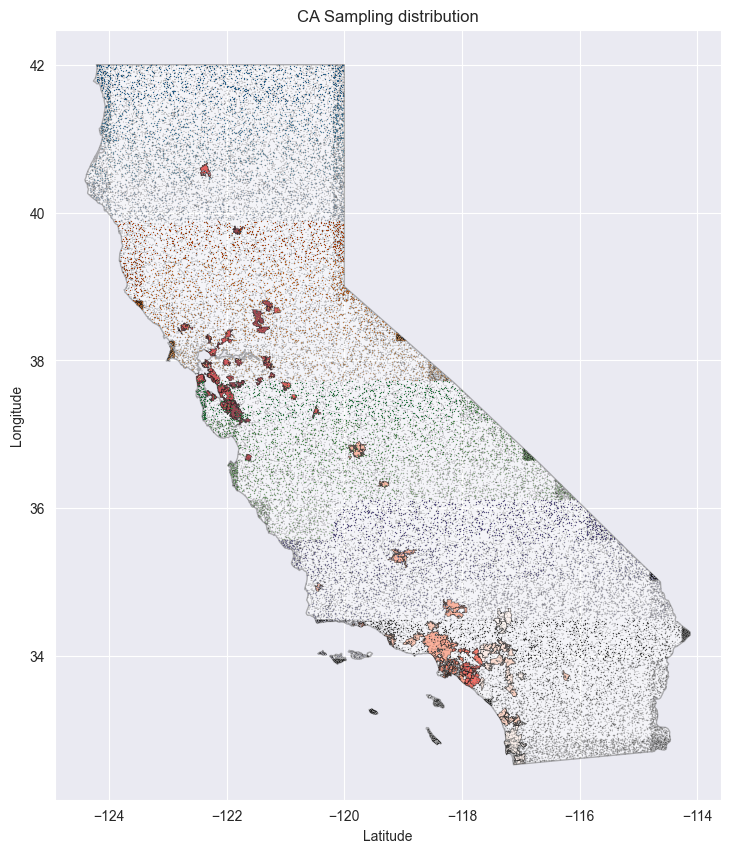

In [708]:
fig, ax = plt.subplots(figsize=(10, 10))

ca.plot(facecolor='white', ax=ax, edgecolor=".4", alpha=0.5)
city_ca.plot(ax=ax, cmap='Reds', linewidth=0.4, edgecolor=".1", alpha=0.7)
tile_gd.plot(column='tile', ax=ax, cmap='tab20c', linewidth=0.1, edgecolor=".1")
ax.set_title('CA Sampling distribution')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()